#### Now integrating drone mechanisms ...

In [157]:
import numpy as np
from numpy.random import default_rng
from scipy.stats import norm
from scipy.special import ndtr
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    Matern,
    ConstantKernel as C,
    WhiteKernel,
)
from dataclasses import dataclass


# Environment and State classes
@dataclass(frozen=True)
class FireEnv:
    grid_size: tuple[int, int]
    domain_km: float
    fuel: np.ndarray          # (nx, ny)
    value: np.ndarray          # (nx, ny)
    wind: np.ndarray           # (T, nx, ny, 2) or (nx, ny, 2) if constant
    dt_s: float                # seconds per CA step
    burn_time_s0: float = 600.0       # initial burn time per cell in seconds
    retardant_half_life_s: float = 1800.0  # seconds
    retardant_k: float = 1.0              # strength in exp(-k * retardant) that downscales hazard in cell with retardant

    drop_w_km: float = 0.2                 # width of retardant drop
    drop_h_km: float = 1                # height of retardant drop
    drop_amount: float = 1.0    # amount of retardant per drop (peak concentration)

@dataclass
class FireState:
    burning: np.ndarray        # (..., nx, ny) bool  (batch dim optional)
    burned: np.ndarray         # (..., nx, ny) bool
    burn_remaining_s: np.ndarray   # (..., nx, ny) float
    retardant: np.ndarray          # (n_sims, nx, ny) float
    t: int = 0
    

class CAFireModel:
    def __init__(self, env: FireEnv, seed: int | None = None):
        self.env = env
        self.base_seed = seed

        nx, _ = env.grid_size
        self.dx = self.env.domain_km / nx 
        self.dx_m = self.dx * 1000.0 # in meters

    def init_state_batch(self, n_sims: int, center, radius_km: float) -> FireState:
        nx, ny = self.env.grid_size
        radius_cells = int(radius_km / self.dx) 
        
        x = np.arange(nx)[:, None]
        y = np.arange(ny)[None, :]
        cx, cy = center
        mask2d = (x - cx) ** 2 + (y - cy) ** 2 <= radius_cells ** 2

        burning = np.zeros((n_sims, nx, ny), dtype=bool)
        burning[:, mask2d] = True

        burned = np.zeros((n_sims, nx, ny), dtype=bool)

        burn_remaining_s = np.broadcast_to(self.env.burn_time_s0, (n_sims, nx, ny)).copy()

        retardant = np.zeros((n_sims, nx, ny), dtype=float)
        return FireState(burning=burning, burned=burned, burn_remaining_s=burn_remaining_s, t=0, retardant=retardant)

    @staticmethod
    def _shift_no_wrap(a: np.ndarray, sx: int, sy: int) -> np.ndarray:
        # a: (n_sims, nx, ny)
        n_sims, nx, ny = a.shape
        out = np.zeros_like(a)

        x_from0 = max(0, -sx)
        x_from1 = min(nx, nx - sx)
        y_from0 = max(0, -sy)
        y_from1 = min(ny, ny - sy)

        x_to0 = max(0, sx)
        x_to1 = min(nx, nx + sx)
        y_to0 = max(0, sy)
        y_to1 = min(ny, ny + sy)

        if x_from0 < x_from1 and y_from0 < y_from1:
            out[:, x_to0:x_to1, y_to0:y_to1] = a[:, x_from0:x_from1, y_from0:y_from1]
        return out

    def step_batch(
        self,
        state: FireState,
        *,
        ros_mps: float = 0.5,
        wind_coeff: float = 0.5,
        diag: bool = True,
    ):
        env = self.env
        dt_s = float(env.dt_s)
        dx_m = float(self.dx_m)

        burning = state.burning
        burned = state.burned

        # RNG
        seed = None if self.base_seed is None else (self.base_seed + state.t)
        rng = np.random.default_rng(seed)

        # -------------------------
        # 0) Retardant decay (half-life)
        # r <- r * exp(-ln(2) * dt / half_life)
        # -------------------------
        hl = float(env.retardant_half_life_s)
        if hl > 0.0:
            decay = np.exp(-np.log(2.0) * dt_s / hl)
            state.retardant *= decay

        # -------------------------
        # 1) Burnout dynamics
        # -------------------------
        state.burn_remaining_s[burning] = np.maximum(0.0, state.burn_remaining_s[burning] - dt_s)
        newly_burned = burning & (state.burn_remaining_s <= 0.0)
        burned[newly_burned] = True
        burning[newly_burned] = False

        if not np.any(burning):
            state.t += 1
            return

        unburned = ~(burning | burned)

        # 2) Wind at time t
        w = env.wind[state.t] if env.wind.ndim == 4 else env.wind
        wx = w[..., 0][None, :, :]
        wy = w[..., 1][None, :, :]

        # 3) Fuel multiplier
        fuel_mul = env.fuel[None, :, :]

        # 4) Baseline hazard
        lambda0 = ros_mps / dx_m  # 1/s

        # 5) Neighborhood
        if diag:
            dirs = [(1, 0), (-1, 0), (0, 1), (0, -1),
                    (1, 1), (1, -1), (-1, 1), (-1, -1)]
        else:
            dirs = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        prob_no = np.ones_like(state.burn_remaining_s, dtype=float)

        # -------------------------
        # Retardant effectiveness: attenuate hazard at target cell
        # lambda_dir *= exp(-k * retardant)
        # -------------------------
        k = float(env.retardant_k)
        retardant_attn = np.exp(-k * np.maximum(state.retardant, 0.0))  # (n_sims,nx,ny) in (0,1]

        for sx, sy in dirs:
            src = self._shift_no_wrap(burning, sx, sy)
            if not np.any(src):
                continue

            dist = float(np.hypot(sx, sy))
            ux, uy = sx / dist, sy / dist

            align = wx * ux + wy * uy
            bias = 1.0 + wind_coeff * np.maximum(0.0, align)

            lambda_dir = (lambda0 / dist) * fuel_mul * bias
            lambda_dir = lambda_dir * retardant_attn 

            p_dir = 1.0 - np.exp(-lambda_dir * dt_s)
            p_dir = np.clip(p_dir, 0.0, 1.0)

            prob_no *= np.where(src, (1.0 - p_dir), 1.0)

        ignite_prob = np.clip(1.0 - prob_no, 0.0, 1.0)
        u = rng.random(size=ignite_prob.shape)
        newly_ignited = unburned & (u < ignite_prob)

        if np.any(newly_ignited):
            burning[newly_ignited] = True
            state.burn_remaining_s[newly_ignited] = float(env.burn_time_s0)

        state.t += 1


    def simulate_burned_probability(
        self,
        T: int,
        n_sims: int,
        center,
        radius_km: float,
        *,
        ros_mps: float = 0.5,
        wind_coeff: float = 0.50,
        diag: bool = True,

    ) -> np.ndarray:
        """
        Returns p_affected[x,y] = P(cell is burning OR burned by time T starting from t=0 ignition).
        - n_sims: number of Monte Carlo simulations to run.
        - center: (x,y) cell coordinates of ignition center.
        - radius_km: ignition radius in kilometers.
        - ros_mps: baseline rate of spread in m/s.
        - wind_coeff: wind alignment boost strength.
        - diag: whether diagonal spread is allowed.
        - T: total simulation time in seconds.
        - returns: p_affected[x,y] in [0,1]
        """

        state = self.init_state_batch(n_sims=n_sims, center=center, radius_km=radius_km)

        num_steps = int(T/self.env.dt_s)
        for _ in range(num_steps):
            self.step_batch(state, ros_mps=ros_mps, wind_coeff=wind_coeff, diag=diag)

        p_affected = (state.burned | state.burning).mean(axis=0)  # (nx, ny) in [0,1]
        return p_affected

    def aggregate_mc_to_state(self,batch_state: FireState) -> FireState:
        """
        Aggregate a batched Monte Carlo FireState -> a single FireState containing probabilities.

        Input:
        batch_state.burning, batch_state.burned: (n_sims,nx,ny) bool
        batch_state.burn_remaining_s:            (n_sims,nx,ny) float

        Output (single-sim state):
        burning[0]: p(burning) in [0,1]
        burned[0]:  p(burned)  in [0,1]
        burn_remaining_s[0]: E[burn_remaining_s | burning] (0 where p(burning)=0)

        Note: this aggregated FireState is for analysis/plotting, not as input to step_batch().
        """
        burning_bool = batch_state.burning
        burned_bool  = batch_state.burned

        p_burning = burning_bool.mean(axis=0)   # (nx,ny)
        p_burned  = burned_bool.mean(axis=0)    # (nx,ny)

        # Conditional mean remaining time among burning cells
        burn_sum = (batch_state.burn_remaining_s * burning_bool).sum(axis=0)
        burn_cnt = burning_bool.sum(axis=0).astype(float)
        burn_mean_cond = np.divide(
            burn_sum, burn_cnt,
            out=np.zeros_like(burn_sum, dtype=float),
            where=(burn_cnt > 0),
        )

        r_mean = batch_state.retardant.mean(axis=0)

        return FireState(
            burning=p_burning[None, :, :],
            burned=p_burned[None, :, :],
            burn_remaining_s=burn_mean_cond[None, :, :],
            retardant=r_mean[None, :, :],
            t=batch_state.t,
    )

    def apply_retardant_cartesian(
        self,
        state: FireState,
        drone_params: np.ndarray | None,
        *,
        drop_w_km: float,
        drop_h_km: float,
        amount: float = 1.0,
    ):
        """
        Add D oriented rectangular retardant drops into state.retardant (in-place).

        drone_params: array of shape (D, 3) with rows (x_i, y_i, phi_i)
        - x_i, y_i in cell coordinates (floats allowed)
        - phi_i in radians, phi=0 => vertical (height along +y)

        drop_w_km / drop_h_km: rectangle width/height in km
        amount: additive retardant load per cell inside each rectangle

        Uses cartesian coordinates for retardant drop placement.
        """
        if drone_params is None:
            return

        drone_params = np.asarray(drone_params, dtype=float)
        if drone_params.size == 0:
            return
        if drone_params.ndim != 2 or drone_params.shape[1] != 3:
            raise ValueError(f"drone_params must have shape (D,3); got {drone_params.shape}")

        n_sims, nx, ny = state.retardant.shape

        # Convert km -> cells
        half_w = 0.5 * (drop_w_km / self.dx)
        half_h = 0.5 * (drop_h_km / self.dx)

        # Coordinate grid in cell indices
        X = np.arange(nx)[:, None]  # (nx,1)
        Y = np.arange(ny)[None, :]  # (1,ny)

        for x0, y0, phi in drone_params:
            xp = X - x0
            yp = Y - y0

            c = np.cos(phi)
            s = np.sin(phi)

            # Rotate points by -phi into rectangle's local frame
            xr = c * xp + s * yp
            yr = -s * xp + c * yp

            mask = (np.abs(xr) <= half_w) & (np.abs(yr) <= half_h)  # (nx,ny)

            # Apply same drop to all sims
            state.retardant[:, mask] += amount


    def simulate_from_ignition(
        self,
        T: int,
        n_sims: int,
        center,
        radius_km: float,
        *,
        drone_params: np.ndarray | None = None,  #Cartesian params
        ros_mps: float = 0.5,
        wind_coeff: float = 0.50,
        diag: bool = True,

    ) -> np.ndarray:
        """
        Same as above simulate_burned_probability, but returns the entire aggregated FireState snapshot for downstream use.
        """

        state = self.init_state_batch(n_sims=n_sims, center=center, radius_km=radius_km)

        self.apply_retardant_cartesian(
            state,
            drone_params,
            drop_w_km=self.env.drop_w_km,
            drop_h_km=self.env.drop_h_km,
            amount=self.env.drop_amount,
        )

        num_steps = int(T/self.env.dt_s)
        for _ in range(num_steps):
            self.step_batch(state, ros_mps=ros_mps, wind_coeff=wind_coeff, diag=diag)

        updated_firestate = self.aggregate_mc_to_state(state)
        return updated_firestate

    def simulate_from_firestate(
        self,
        init_firestate: FireState,
        T: float,
        n_sims: int,
        *,
        drone_params: np.ndarray | None = None,  #Cartesian params
        ros_mps: float = 0.5,
        wind_coeff: float = 0.50,
        diag: bool = True,
        seed: int | None = None,
    ) -> FireState:
        """
        Simulate forward for T seconds starting from init_firestate, using n_sims MC runs,
        then return the aggregated FireState (probability maps).

        - If init_firestate is boolean (a concrete state / batch of states), we replicate/tile to n_sims.
        - If init_firestate is probabilistic (aggregated; float), we sample an n_sims boolean ensemble.

        NOTE: We re-sample n_sims from the distribution defined by the init_firestate (i.e. MC noise is present at t=0) to intialise each batched run.
        """
        nx, ny = self.env.grid_size
        dt_s = float(self.env.dt_s)
        num_steps = int(np.ceil(float(T) / dt_s))

        if seed is None:
            seed = None if getattr(self, "base_seed", None) is None else (self.base_seed + int(init_firestate.t))
        rng = np.random.default_rng(seed)

        def _ensure_batched(arr, dtype=None):
            a = np.asarray(arr)
            if dtype is not None:
                a = a.astype(dtype, copy=False)
            if a.ndim == 2:
                a = a[None, :, :]
            if a.shape[1:] != (nx, ny):
                raise ValueError(f"Expected shape (*,{nx},{ny}), got {a.shape}")
            return a

        burning0 = _ensure_batched(init_firestate.burning)
        burned0  = _ensure_batched(init_firestate.burned)
        br0      = _ensure_batched(init_firestate.burn_remaining_s, dtype=float)
        ret0 = _ensure_batched(init_firestate.retardant, dtype=float)
        t0       = int(init_firestate.t)
        

        # Case 1: concrete/batched boolean state -> replicate/tile to n_sims
        if burning0.dtype == bool and burned0.dtype == bool:
            m = burning0.shape[0]
            if m == n_sims:
                burning = burning0.copy()
                burned  = burned0.copy()
                burn_remaining_s = br0.copy()
            else:
                # tile (copying trajectories) to reach n_sims
                reps = int(np.ceil(n_sims / m))
                burning = np.tile(burning0, (reps, 1, 1))[:n_sims].copy()
                burned  = np.tile(burned0,  (reps, 1, 1))[:n_sims].copy()
                burn_remaining_s = np.tile(br0, (reps, 1, 1))[:n_sims].copy()

            # consistency
            burning &= ~burned
            burn_remaining_s[burned] = 0.0

            retardant = ret0.copy() if m == n_sims else np.tile(ret0, (reps, 1, 1))[:n_sims].copy()

            state = FireState(burning=burning, burned=burned, burn_remaining_s=burn_remaining_s, retardant=retardant, t=t0)

        # Case 2: aggregated/probabilistic state -> sample boolean ensemble of size n_sims
        else:
            p_burning = burning0[0].astype(float, copy=False)
            p_burned  = burned0[0].astype(float, copy=False)

            p_burned = np.clip(p_burned, 0.0, 1.0)
            p_burning = np.clip(p_burning, 0.0, 1.0)
            p_burning = np.minimum(p_burning, 1.0 - p_burned)

            u = rng.random((n_sims, nx, ny))
            burned  = u < p_burned[None, :, :]
            burning = (u >= p_burned[None, :, :]) & (u < (p_burned + p_burning)[None, :, :])

            burn_remaining_s = np.zeros((n_sims, nx, ny), dtype=float)

            br_map = br0[0]  # (nx, ny)
            burn_remaining_s[burning] = np.broadcast_to(br_map, (n_sims, nx, ny))[burning]

            burn_remaining_s[burned] = 0.0

            ret_map = ret0[0]  # (nx, ny)
            retardant = np.broadcast_to(ret_map, (n_sims, nx, ny)).copy()
            state = FireState(burning=burning, burned=burned, burn_remaining_s=burn_remaining_s, retardant=retardant, t=t0)

        self.apply_retardant_cartesian(
            state,
            drone_params,
            drop_w_km=self.env.drop_w_km,
            drop_h_km=self.env.drop_h_km,
            amount=self.env.drop_amount,
        )

        # Roll forward
        for _ in range(num_steps):
            self.step_batch(state, ros_mps=ros_mps, wind_coeff=wind_coeff, diag=diag)

        return self.aggregate_mc_to_state(state)

    def plot_firestate(
        self,
        state,
        *,
        sim_idx: int = 0,
        kind: str = "auto",          # "auto" | "discrete" | "p_burning" | "p_burned" | "p_affected" | "burn_remaining"
        title: str | None = None,
        extent_km: float | None = None,  # set to domain_km if you want km axes; else cell indices
    ):
        """
        Visualise a FireState.

        - If state.burning is bool -> can plot discrete state (0/1/2) for sim_idx.
        - If state.burning is float -> interpreted as probabilities, plots heatmaps.
        """
        burning = state.burning[sim_idx]
        burned  = state.burned[sim_idx]
        brs     = state.burn_remaining_s[sim_idx]

        is_prob = np.issubdtype(burning.dtype, np.floating) or np.issubdtype(burned.dtype, np.floating)

        if kind == "auto":
            kind = "p_affected" if is_prob else "discrete"

        if extent_km is not None:
            extent = [0, extent_km, 0, extent_km]
            xlabel, ylabel = "x (km)", "y (km)"
        else:
            extent = None
            xlabel, ylabel = "x cell", "y cell"

        plt.figure(figsize=(6, 5))

        if kind == "discrete":
            # 0=unburned, 1=burning, 2=burned
            s = np.zeros_like(burning, dtype=np.int8)
            s[burning.astype(bool)] = 1
            s[burned.astype(bool)] = 2
            im = plt.imshow(s.T, origin="lower", aspect="equal", extent=extent)
            plt.colorbar(im, ticks=[0, 1, 2], label="State (0=unburned, 1=burning, 2=burned)")

        elif kind == "p_burning":
            im = plt.imshow(np.clip(burning, 0, 1).T, origin="lower", vmin=0, vmax=1, aspect="equal", extent=extent)
            plt.colorbar(im, label="P(burning)")

        elif kind == "p_burned":
            im = plt.imshow(np.clip(burned, 0, 1).T, origin="lower", vmin=0, vmax=1, aspect="equal", extent=extent)
            plt.colorbar(im, label="P(burned)")

        elif kind == "p_affected":
            # For probabilities, affected ≈ p_burning + p_burned (clip to [0,1]).
            # For booleans, this is simply burning OR burned.
            affected = (burning | burned) if (burning.dtype == bool and burned.dtype == bool) else np.clip(burning + burned, 0, 1)
            im = plt.imshow(affected.T, origin="lower", vmin=0, vmax=1, aspect="equal", extent=extent)
            plt.colorbar(im, label="P(burning or burned)" if is_prob else "Affected (burning or burned)")

        elif kind == "burn_remaining":
            im = plt.imshow(brs.T, origin="lower", aspect="equal", extent=extent)
            plt.colorbar(im, label="Burn remaining (s)")

        elif kind == "retardant":
            r = state.retardant[sim_idx]
            im = plt.imshow(r.T, origin="lower", aspect="equal", extent=extent)
            plt.colorbar(im, label="Retardant load")

        else:
            raise ValueError(f"Unknown kind={kind}")

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title if title is not None else f"{kind} at t={state.t}")
        plt.tight_layout()
        plt.show()
        
    @staticmethod
    def state_int_single(state: FireState, sim_idx: int = 0) -> np.ndarray:
        s = np.zeros(state.burning.shape[1:], dtype=np.int8)
        s[state.burning[sim_idx]] = 1
        s[state.burned[sim_idx]] = 2
        return s

    def plot_single_run(self, state: FireState, sim_idx: int = 0, title: str | None = None):
        """ For plotting the output of a single simulation in a batch. """
        s = self.state_int_single(state, sim_idx=sim_idx)
        plt.figure(figsize=(6, 5))
        plt.imshow(s.T, origin="lower", aspect="equal")
        plt.colorbar(ticks=[0, 1, 2], label="State (0=unburned, 1=burning, 2=burned)")
        plt.xlabel("x cell")
        plt.ylabel("y cell")
        plt.title(title if title is not None else f"Fire state at t={state.t}")
        plt.tight_layout()
        plt.show()

    def plot_probability_map(
        self,
        p_map: np.ndarray,
        *,
        title: str | None = None,
        cbar_label: str = "P(burned by T)",
        extent_km: bool = True,
    ):
        """ For plotting the output of simulate_burned_probability. """
        nx, ny = self.env.grid_size
        extent = [0, self.env.domain_km, 0, self.env.domain_km] if extent_km else None

        plt.figure(figsize=(6, 5))
        im = plt.imshow(
            p_map.T,
            origin="lower",
            vmin=0.0,
            vmax=1.0,
            aspect="equal",
            extent=extent,
        )
        plt.colorbar(im, label=cbar_label)
        plt.xlabel("x (km)" if extent_km else "x cell")
        plt.ylabel("y (km)" if extent_km else "y cell")
        plt.title(title if title is not None else "Monte Carlo burned probability map")
        plt.tight_layout()
        plt.show()

### Evolving fire with no retardant involved

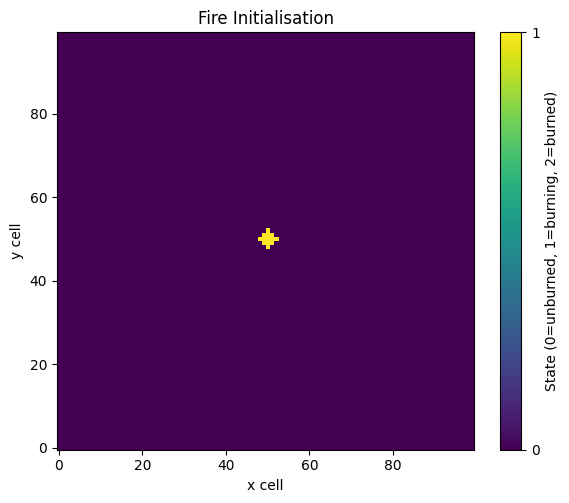

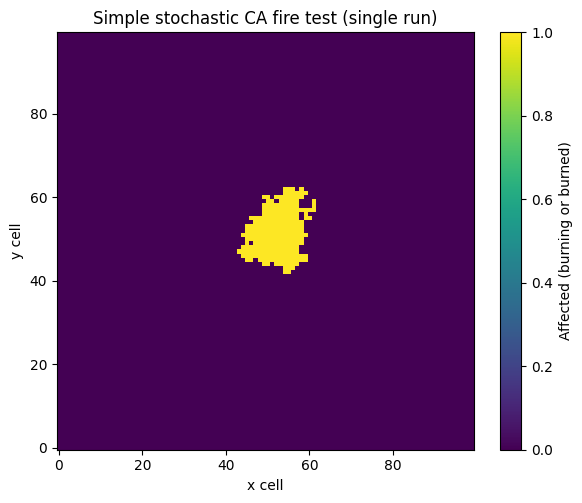

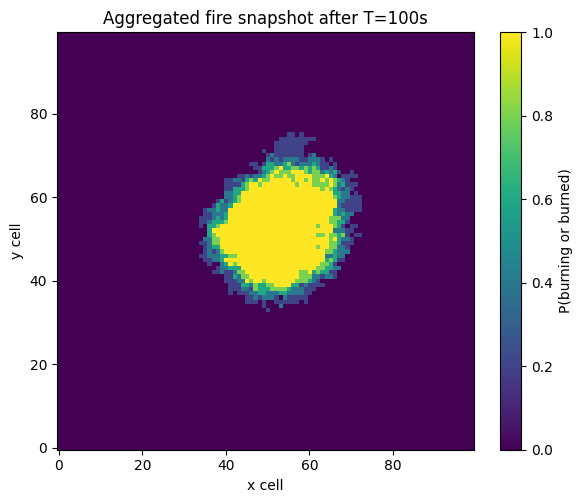

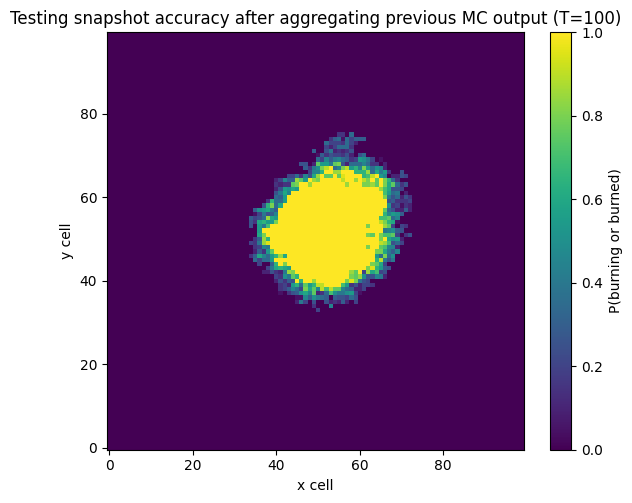

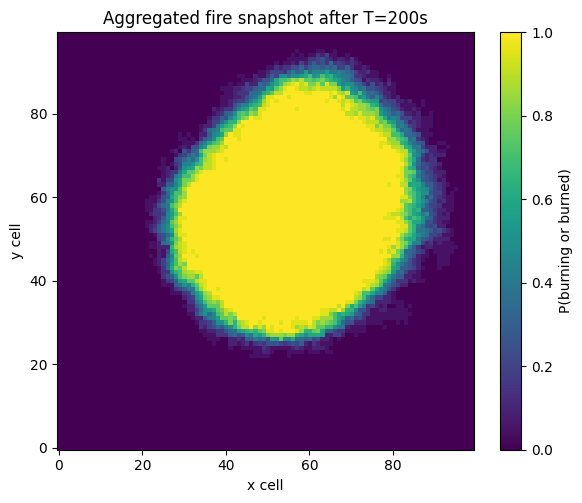

In [158]:
# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 2
wind[..., 1] = 2

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
)

model = CAFireModel(default_env, seed=123)

state = model.init_state_batch(n_sims=3, center=(50, 50), radius_km=0.2)

model.plot_firestate(state, title="Fire Initialisation")

for _ in range(60):
    model.step_batch(state, ros_mps=2, wind_coeff=0.6, diag=True)

model.plot_firestate(state,  kind="p_affected", title="Simple stochastic CA fire test (single run)")


fire_snapshot = model.simulate_from_ignition(
    T=100, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")

updated_fire_snapshot = model.simulate_from_firestate(
    fire_snapshot, T=0, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(updated_fire_snapshot, kind="p_affected", title="Testing snapshot accuracy after aggregating previous MC output (T=100)")

reupdated_fire_snapshot = model.simulate_from_firestate(
    updated_fire_snapshot, T=100, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(reupdated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=200s")

with retardant barrier:


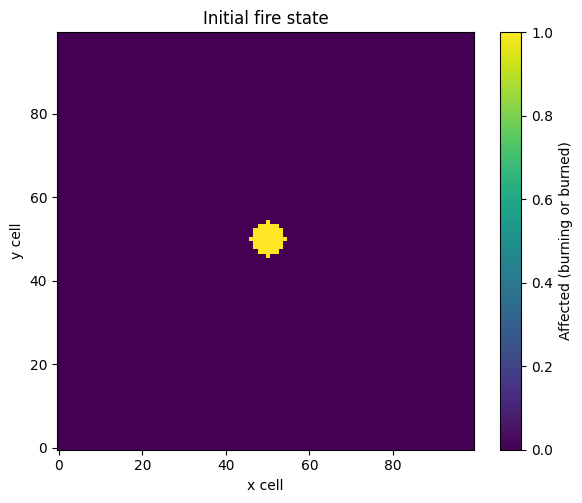

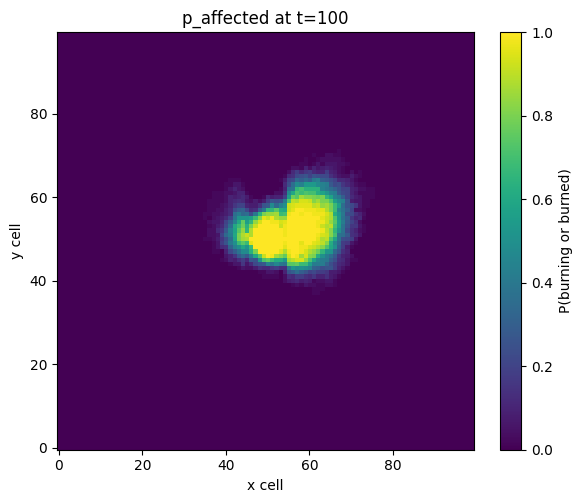

without retardant barrier:
with retardant barrier:


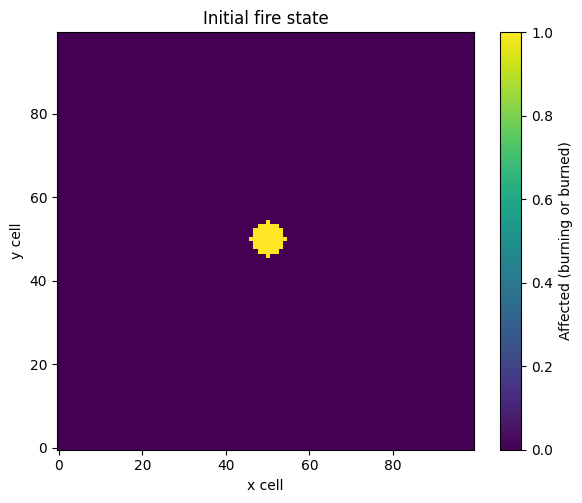

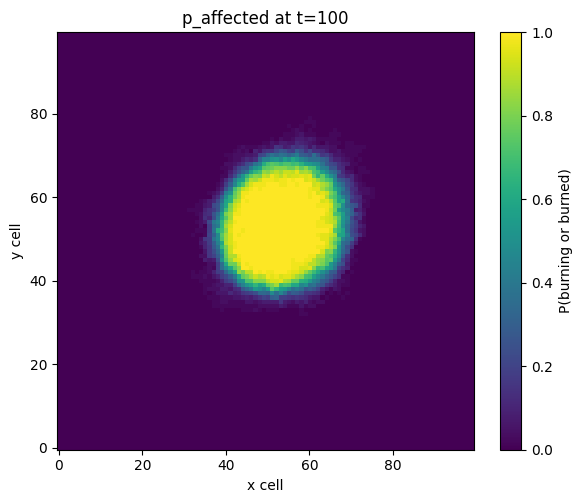

In [159]:
# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 2
wind[..., 1] = 2

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 100, #small for testing
    retardant_k = 1.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)

state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)
state.retardant[:, 45:55, 20:80] = 2.0  # barrier

print('with retardant barrier:')
model.plot_firestate(state, kind="p_affected", title="Initial fire state")
#model.plot_firestate(state, kind="retardant", title="Initial retardant barrier")


for _ in range(100):
    model.step_batch(state, ros_mps=2.0, wind_coeff=0.6)

agg = model.aggregate_mc_to_state(state)
model.plot_firestate(agg, kind="p_affected")
#model.plot_firestate(agg, kind="retardant")

print('without retardant barrier:')

state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

print('with retardant barrier:')
model.plot_firestate(state, kind="p_affected", title="Initial fire state")

for _ in range(100):
    model.step_batch(state, ros_mps=2.0, wind_coeff=0.6)

agg = model.aggregate_mc_to_state(state)
model.plot_firestate(agg, kind="p_affected")

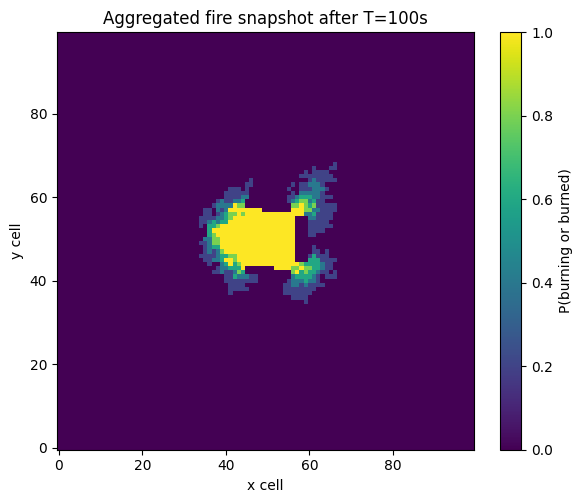

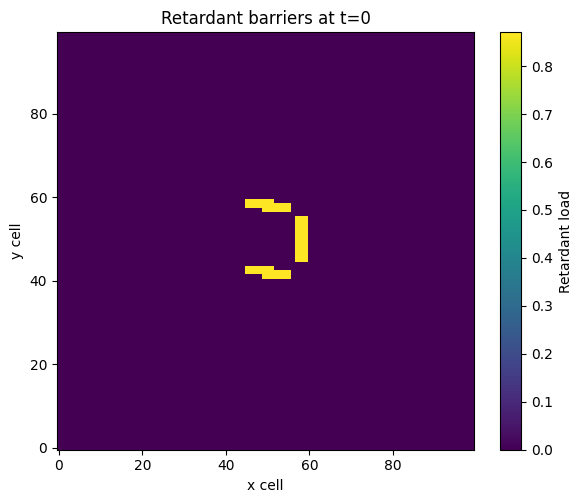

'updated_fire_snapshot = model.simulate_from_firestate(\n    fire_snapshot, T=0, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True\n)\n\nmodel.plot_firestate(updated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")\n\nreupdated_fire_snapshot = model.simulate_from_firestate(\n    updated_fire_snapshot, T=100, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True\n)\n\nmodel.plot_firestate(reupdated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=200s")'

In [161]:
# phi=0 => vertical, phi=pi/2 => horizontal
drone_params = np.array([
    #[42.0, 50.0, 0.0],          # left vertical barrier
    [58.0, 50.0, 0.0],          # right vertical barrier
    [50.0, 58.0, np.pi/2],      # top horizontal barrier
    [50.0, 42.0, np.pi/2],      # bottom horizontal barrier
], dtype=float)

# Constant wind: mild south-westerly
wind=np.zeros((100, 100, 2))
wind[..., 0] = 1
wind[..., 1] = 1

default_env = FireEnv(
    grid_size=(100, 100),
    domain_km=10.0,
    fuel=np.ones((100, 100)),
    value=np.ones((100, 100)),
    wind=wind,
    burn_time_s0=300.0,
    dt_s=1.0,
    retardant_half_life_s = 500, #small for testing
    retardant_k = 10.0,          #strong for testing
)

model = CAFireModel(default_env, seed=123)
state = model.init_state_batch(n_sims=50, center=(50,50), radius_km=0.4)

fire_snapshot = model.simulate_from_ignition(
    T=100, n_sims=5, center=(50, 50), radius_km=0.4,
    ros_mps=2, wind_coeff=0.6, diag=True, drone_params=drone_params,
)

model.plot_firestate(fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")

model.plot_firestate(fire_snapshot, kind="retardant", title="Retardant barriers at t=0")


"""updated_fire_snapshot = model.simulate_from_firestate(
    fire_snapshot, T=0, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(updated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=100s")

reupdated_fire_snapshot = model.simulate_from_firestate(
    updated_fire_snapshot, T=100, n_sims=20, ros_mps=2, wind_coeff=0.6, diag=True
)

model.plot_firestate(reupdated_fire_snapshot, kind="p_affected", title="Aggregated fire snapshot after T=200s")"""